In [1]:
import numpy as np
import seaborn as sns
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv

# https://biopython.org/docs/1.74/api/Bio.SVDSuperimposer.html
from Bio.SVDSuperimposer import SVDSuperimposer

from numpy import array, dot, set_printoptions

In [2]:
# link to openmm manual for how to set up a minimizer
# http://docs.openmm.org/7.2.0/userguide/application.html

In [3]:
def get_rot_and_trans(subtraj_A,subtraj_B):
    """ fit only works now on a single frame (mdtraj returns xyz with shape (n_frames, atoms, xyz) 
         even for single frame trajs so hence the xyz[0]"""
    
    # load super imposer
    sup = SVDSuperimposer()

    # Set the coords, y will be rotated and translated on x
    x = subtraj_A.xyz[0]
    y = subtraj_B.xyz[0]
    sup.set(x, y)

    # Do the leastsquared fit
    sup.run()

    # Get the rms
    rms = sup.get_rms()

    # Get rotation (right multiplying!) and the translation
    rot, tran = sup.get_rotran()
    
    # now we have the instructions to rotate B on A
    return rot,tran,rms


def apply_superimposition(traj, rot, tran):
    
    # get xyz coordinates
    xyz = traj.xyz[0]
    
    # rotate subject on target
    new_xyz = dot(xyz, rot) + tran

    # replace coordinates of traj
    traj.xyz = new_xyz
    return traj

def fit_B_on_A(A, B, selection_A, selection_B, delete_overlap=False):
    
    # create trajs containing only the selections
    subtraj_A = A.atom_slice(selection_A)
    subtraj_B = B.atom_slice(selection_B)

    # obtain instructions to rotate and translate B on A based on substraj structures
    rot, tran, rms = get_rot_and_trans(subtraj_A,subtraj_B)
    
    # do the superimposition of B on A and subsitute old with new xyz of B
    new_B = apply_superimposition(B, rot, tran)
    
    if delete_overlap:
        # remove selection from A and add new B
        selection_to_delete = selection_A 
        C = A.atom_slice([at.index for at in A.top.atoms if at.index not in selection_to_delete]).stack(new_B)
        
    else:
        C = A.stack(new_B)
            
    return C, rms

def check_selection(top,selection):
    if selection == 'CA':
        indices = top.select('name CA')
    elif selection == 'backbone':
        indices = top.select('backbone')
    elif selection == 'sidechain':
        indices = top.select('sidechain')
    else:
        indices = top.select('all')   
    return indices 

def get_monomer_domain_indices(top,domain,chain=0,selection=None):
    residues = np.array(top._chains[chain]._residues)
    indices = check_selection(top,selection)
    return [at.index for res in residues[domain] for at in res.atoms if at.index in indices]
    

def show_domain(system,domain):
    # shows first frame
    top = system.top
    view = nv.show_mdtraj(system[0])
    view.clear()
    indices = get_monomer_domain_indices(top,domains[domain],chain=0)
    view.add_representation('cartoon',selection=[i for i in  top.select('all') if i not in indices],color='cornflowerblue')
    top = system.topology
    chain_id = 0
    indices = get_monomer_domain_indices(top,domains[domain],chain=chain_id)
    view.add_representation('cartoon',selection=indices,color='gold')
    top = system.topology
    chain_id = 1
    indices = get_monomer_domain_indices(top,domains[domain],chain=chain_id)
    view.add_representation('cartoon',selection=indices,color='red')
    return view


# top = s1s1.topology
# chain_id = 0
# domain = 's1'
# # selection options are CA (carbon alpha), backbone, and sidechain, or None (all)
# indices = get_monomer_domain_indices(top,domains[domain],chain=chain_id,selection='CA')

In [4]:
# Load H-NS s1s1 dimers
loc_dimers = './data/0_s1s1/drytrajs/'
short_trajs = [md.load(loc_dimers+f'dry_{i}.xtc',top=loc_dimers+f'dry_{i}.pdb').remove_solvent() for i in range(0,16)]
#start_open = md.load(loc_dimers+f'dry_open.xtc',top=loc_dimers+f'dry_open.pdb').remove_solvent()
#start_closed = md.load(loc_dimers+f'dry_closed.xtc',top=loc_dimers+f'dry_closed.pdb').remove_solvent()

#s1s1 = md.join([start_open,start_closed,md.join(short_trajs)])
s1s1 = md.join(short_trajs)

In [5]:
# Load H-NS s2s2 dimers
loc_dimers = './data/1_s2s2/drytrajs/'
short_trajs = [md.load(loc_dimers+f'dry_{i}.xtc',top=loc_dimers+f'dry_{i}.pdb').remove_solvent() for i in range(0,10)]

s2s2 = md.join(short_trajs)

In [6]:
domains = {'s1':np.arange(0,41),
           's2':np.arange(53,82),
           'dbd':np.arange(95,137),
           'h1':np.arange(1,8),
           'h2':np.arange(11,19),
           'h3':np.arange(41,50),
           'l1':np.arange(50,53),
           'h4':np.arange(71,82),
           'l2':np.arange(82,95),
           'all':np.arange(0,137)}

In [7]:
show_domain(s1s1[100],'s1')

NGLWidget()

In [8]:
show_domain(s2s2,'s1')

NGLWidget()

## Create tertramer based on s2s2 dimer by complete fit of site1 of s1s1 dimer

In [9]:
tree = None
temp = None

In [10]:
# select starting structure of site2 dimer
seed = s2s2[100]

# select starting structure of site1 dimer
branch = s1s1[1200]

# get site 1 indices of both seed and branch of chain 0 and chain 1
seed_s1 = [get_monomer_domain_indices(seed.top, domains['s1'], chain=cid) for cid in [0,1]]
branch_s1 = [get_monomer_domain_indices(branch.top, domains['s1'], chain=cid) for cid in [0,1]]

# graft chain 0 of branch to s1 of seed chain 0 
temp = fit_B_on_A(seed,branch,seed_s1[0],branch_s1[0],delete_overlap=False)
tree = fit_B_on_A(temp[0],branch,seed_s1[1],branch_s1[0])
tetramer = tree[0].atom_slice(tree[0].top.select('chainid 0 1 3 5'))
tetramer.top

<mdtraj.Topology with 4 chains, 548 residues, 8780 atoms, 8812 bonds at 0x17f2b0880>

In [11]:
view = nv.show_mdtraj(tetramer)
view

NGLWidget()

### Create filaments by grafting s1s1 and s2s2 dimers

In [12]:
def get_rot_and_trans(subtraj_A,subtraj_B):
    
    """ fit only works now on a single frame (mdtraj returns xyz with shape (n_frames, atoms, xyz) 
         even for single frame trajs so hence the xyz[0]"""
    
    # load super imposer
    sup = SVDSuperimposer()

    # Set the coords, y will be rotated and translated on x
    x = subtraj_A.xyz[0]
    y = subtraj_B.xyz[0]
    sup.set(x, y)

    # Do the leastsquared fit
    sup.run()

    # Get the rms
    rms = sup.get_rms()

    # Get rotation (right multiplying!) and the translation
    rot, tran = sup.get_rotran()
    
    # now we have the instructions to rotate B on A
    return rot,tran,rms

def apply_superimposition(traj, rot, tran):
    
    # get xyz coordinates
    xyz = traj.xyz[0]
    
    # rotate subject on target
    new_xyz = dot(xyz, rot) + tran

    # replace coordinates of traj
    traj.xyz = new_xyz
    return traj

def update_topology(C):
    top = C.top
    # Merge two tops (with two chains or more) to a top of one chain 
    out = md.Topology()
    c = out.add_chain()
    for chain in top.chains:

        for residue in chain.residues:
            r = out.add_residue(residue.name, c, residue.resSeq, residue.segment_id)
            for atom in residue.atoms:
                out.add_atom(atom.name, atom.element, r, serial=atom.serial)
    #     for bond in top.bonds:
    #         a1, a2 = bond
    #         out.add_bond(a1, a2, type=bond.type, order=bond.order)
    out.create_standard_bonds() #rare manier om bonds te maken, maar werkt
    C.top = out 
    return C

# def fit_B_on_A(A, B, selection_A, selection_B, delete_overlap=False, leading_chain=0):
    
#     # create trajs containing only the selections
#     subtraj_A = A.atom_slice(selection_A)
#     subtraj_B = B.atom_slice(selection_B)

#     # obtain instructions to rotate and translate B on A based on substraj structures
#     rot, tran, rms = get_rot_and_trans(subtraj_A,subtraj_B)
    
#     # do the superimposition of B on A and subsitute old with new xyz of B
#     new_B = apply_superimposition(B, rot, tran)

    
#     if delete_overlap:
#         # remove selection from A and add new B
#         selection_to_delete = selection_A 
#         new_A = A.atom_slice([at.index for at in A.top.atoms if at.index not in selection_to_delete])

#         # merge superimposed structure and fit (A and B*) and update topology such that they share a chain
#         C = update_topology(new_A.stack(new_B),leading_chain)
#     else:
#          C = A.stack(new_B)
            
#     return C, rms

# def fit_B_on_A(A,B,overlap_A,overlap_B,leading_chain):
    
#     # create trajs containing only the selections
#     subtraj_A = A.atom_slice(overlap_A)
#     subtraj_B = B.atom_slice(overlap_B)

#     # obtain instructions to rotate and translate B on A based on substraj structures
#     rot, tran, rms = get_rot_and_trans(subtraj_A,subtraj_B)

#     # do the superimposition of B on A and subsitute old with new xyz of B
#     new_B = apply_superimposition(B, rot, tran)


#     # remove selection from A and add new B
#     selection_to_delete = overlap_A 
#     new_A = A.atom_slice([at.index for at in A.top.atoms if at.index not in selection_to_delete])

#     # split part of A in chain that is being extended and that is not
#     A_active = new_A.atom_slice(new_A.top.select(f'chainid {leading_chain}'))
#     A_passive = new_A.atom_slice(new_A.top.select(f'not chainid {leading_chain}'))

#     # add B to active part of A (and make sure they are in same chain)
#     temp = update_topology(A_active.stack(new_B))

#     # combine passive part with new structure (active part of A and B)
#     return A_passive.stack(temp)

In [13]:
def get_overlap(a,b):
    return list(set(a).intersection(b))


pairs = [['s1','h3'],
         ['h3','s2'],
         ['s2','l2'],
         ['l2','dbd']]
n = 2

segments = {'s1':np.arange(0,41+n),
            'h3':np.arange(41-n,53+n),
            's2':np.arange(53-n,82+n),
            'l2':np.arange(82-n,95+n),
            'dbd':np.arange(95-n,137)}

In [14]:
def get_segment_structures(traj,segments,site='dbd'):
    chain_a = get_monomer_domain_indices(top=traj.top, domain=segments[site], chain=0, selection=None)
    chain_b = get_monomer_domain_indices(top=traj.top, domain=segments[site], chain=1, selection=None)
    A = traj.atom_slice(chain_a)
    B = traj.atom_slice(chain_b)
    return md.join([A,B])

def get_site_structures(traj,segements,site='s1'):
    chain_a = get_monomer_domain_indices(top=traj.top, domain=segments[site], chain=0, selection=None)
    chain_b = get_monomer_domain_indices(top=traj.top, domain=segments[site], chain=1, selection=None)
    return traj.atom_slice(np.sort(chain_a+chain_b))


# segments = {'s1':np.arange(0,41+n),
#             'h3':np.arange(41-n,53+n),
#             's2':np.arange(53-n,82+n),
#             'l2':np.arange(82-n,95+n),
#             'dbd':np.arange(95-n,137)}

k = 100
s1 = get_site_structures(s1s1,segments,site='s1')[::k]
s2 = get_site_structures(s2s2,segments,site='s2')[::k]

h3_s1s1 = get_segment_structures(s1s1,segments,site='h3')
h3_s2s2 = get_segment_structures(s2s2,segments,site='h3')
h3 = md.join([h3_s1s1,h3_s2s2])[::k]

l2_s1s1 = get_segment_structures(s1s1,segments,site='l2')
l2_s2s2 = get_segment_structures(s2s2,segments,site='l2')
l2 = md.join([l2_s1s1,l2_s2s2])[::k]

dbd_s1s1 = get_segment_structures(s1s1,segments,site='dbd')
dbd_s2s2 = get_segment_structures(s2s2,segments,site='dbd')
dbd = md.join([dbd_s1s1,dbd_s2s2])[::k]

<mdtraj.Trajectory with 201 frames, 1444 atoms, 86 residues, and unitcells at 0x17dfd6c20>

In [16]:
site_map = {'s1':s1,
           'h3':h3,
           's2':s2,
           'l2':l2,
           'dbd':dbd}


chain_order = np.array(['s1','h3','s2','l2','dbd'])
pairs = [[a,b] for a,b in zip(chain_order[:-1],chain_order[1:])]

In [171]:
fasta_map = {site:traj.top.to_fasta() for site,traj in site_map.items()}

In [166]:
print(np.array(list(fasta_map['s1'][0]))[segments['s1']])
print(fasta_map['s1'][1])
print(fasta_map['h3'][0])

['M' 'S' 'E' 'A' 'L' 'K' 'I' 'L' 'N' 'N' 'I' 'R' 'T' 'L' 'R' 'A' 'Q' 'A'
 'R' 'E' 'C' 'T' 'L' 'E' 'T' 'L' 'E' 'E' 'M' 'L' 'E' 'K' 'L' 'E' 'V' 'V'
 'V' 'N' 'E' 'R' 'R' 'E' 'E']
MSEALKILNNIRTLRAQARECTLETLEEMLEKLEVVVNERREE
RREEESAAAAEVEERT


In [175]:
site_map['s1'].top._chains[0]._residues

[MET1,
 SER2,
 GLU3,
 ALA4,
 LEU5,
 LYS6,
 ILE7,
 LEU8,
 ASN9,
 ASN10,
 ILE11,
 ARG12,
 THR13,
 LEU14,
 ARG15,
 ALA16,
 GLN17,
 ALA18,
 ARG19,
 GLU20,
 CYS21,
 THR22,
 LEU23,
 GLU24,
 THR25,
 LEU26,
 GLU27,
 GLU28,
 MET29,
 LEU30,
 GLU31,
 LYS32,
 LEU33,
 GLU34,
 VAL35,
 VAL36,
 VAL37,
 ASN38,
 GLU39,
 ARG40,
 ARG41,
 GLU42,
 GLU43]

In [97]:
def get_overlap_indices(top,n,chain=0,terminus=None):
    residues = np.array(top._chains[chain]._residues)
    if terminus == 'N_terminus': # get residues at end of chain
        s = residues[len(residues)-n*2:len(residues)]
        return [at.index for res in s for at in res.atoms]
    elif terminus == 'C_terminus': # get residues at beginning of chain
        s = residues[:n*2]
        return [at.index for res in s for at in res.atoms]
    else:
        print('No terminus')
        
def check_if_dimerization(site):
    if 's' in site:
        return True
    else:
        return False
    
def get_termini(site_x,site_y):
    chain_order = np.array(['s1','h3','s2','l2','dbd'])
    x = np.argwhere(chain_order==site_x)
    y = np.argwhere(chain_order==site_y)
    if x < y:
        return ['N_terminus','C_terminus']
    elif x > y:
        return ['C_terminus','N_terminus']
    
def fit_B_on_A(A, B, overlap_A, overlap_B):
    # create trajs containing only the selections
    subtraj_A = A.atom_slice(overlap_A)
    subtraj_B = B.atom_slice(overlap_B)

    # obtain instructions to rotate and translate B on A based on substraj structures
    rot, tran, rms = get_rot_and_trans(subtraj_A,subtraj_B)

    # do the superimposition of B on A and subsitute old with new xyz of B
    return apply_superimposition(B, rot, tran)
    
def remove_overlap(traj,overlap):
     return traj.atom_slice([at.index for at in traj.top.atoms if at.index not in overlap])
    
def split_chain_topology(traj,leading_chain):
    # split part of A in chain that is being extended and that is not
    traj_active = traj.atom_slice(traj.top.select(f'chainid {leading_chain}'))
    traj_passive = traj.atom_slice(traj.top.select(f'not chainid {leading_chain}'))
    return traj_active, traj_passive

def merge_chain_topology(A,B,keep_resSeq=True):
    C = A.stack(B,keep_resSeq=keep_resSeq)
    top = C.top
    # Merge two tops (with two chains or more) to a top of one chain 
    out = md.Topology()
    c = out.add_chain()
    for chain in top.chains:

        for residue in chain.residues:
            r = out.add_residue(residue.name, c, residue.resSeq, residue.segment_id)
            for atom in residue.atoms:
                out.add_atom(atom.name, atom.element, r, serial=atom.serial)
    #     for bond in top.bonds:
    #         a1, a2 = bond
    #         out.add_bond(a1, a2, type=bond.type, order=bond.order)
    out.create_standard_bonds() #rare manier om bonds te maken, maar werkt
    C.top = out 
    return C

In [108]:
def add_pair(traj,pair,site_map,leading_chain=0,adding_chain=0,verbose=False):
    keep_resSeq = True
    A,B,C=None,None,None
    site_a, site_b = pair
    print(site_a,site_b)
    if not traj:
        A = site_map[site_a][40]
        B = site_map[site_b][90]
    else:
        A = traj
        B = site_map[site_b][40]
        
    # check if site had dimerization site
    dimer_a = check_if_dimerization(site_a)
    dimer_b = check_if_dimerization(site_b)
    if verbose:
        print(dimer_a, dimer_b)
        
    # get_termini of site a and b
    terminus_a, terminus_b = get_termini(site_a,site_b)
    if verbose:
        print(terminus_a, terminus_b)
        
    # get atom indices of overlapping segements
    overlap_A = get_overlap_indices(A.top,n,chain=leading_chain,terminus=terminus_a)
    overlap_B = get_overlap_indices(B.top,n,chain=adding_chain,terminus=terminus_b)
    
    if len(overlap_A) != len(overlap_B):
        print(len(overlap_A),len(overlap_B))
        print('Something went wrong with finding the overlaps')
        return traj
         
    # obtain superimposition of B on A
    new_B = fit_B_on_A(A,B,overlap_A,overlap_B)
    
    # remove overlapping selection from A used for fit
    new_A = remove_overlap(A,overlap_A)
    
    # splits topology in leading chain and remainder (not leading chain(s))
    A_active, A_passive = split_chain_topology(new_A,leading_chain)
    
    if dimer_b:
        # splits topology in leading chain and remainder (not adding chain(s))
        B_active, B_passive = split_chain_topology(new_B,adding_chain)
            
        # add B to active part of A (and make sure they are in same chain)
        temp = merge_chain_topology(A_active,B_active)
        C_temp = temp.stack(A_passive,keep_resSeq=keep_resSeq)
        C =  C_temp.stack(B_passive,keep_resSeq=keep_resSeq)
    else:
        # add B to active part of A (and make sure they are in same chain)
        temp = merge_chain_topology(A_active,new_B)
        # combine passive part with new structure (active part of A and B)
        C = temp.stack(A_passive,keep_resSeq=keep_resSeq)
    return C

In [223]:
def add_pair(traj,pair,site_map,leading_chain=0,adding_chain=0,verbose=False,reverse=False):
    keep_resSeq = False
    A,B,C=None,None,None
    site_a, site_b = pair
    print(site_a,site_b)
    if not traj:
        A = site_map[site_a][40]
        B = site_map[site_b][90]
    else:
        A = traj
        B = site_map[site_b][40]
        
    # check if site had dimerization site
    dimer_a = check_if_dimerization(site_a)
    dimer_b = check_if_dimerization(site_b)
    if verbose:
        print(dimer_a, dimer_b)
        
    # get_termini of site a and b
    terminus_a, terminus_b = get_termini(site_a,site_b)
    if verbose:
        print(terminus_a, terminus_b)
        
    # get atom indices of overlapping segements
    overlap_A = get_overlap_indices(A.top,n,chain=leading_chain,terminus=terminus_a)
    overlap_B = get_overlap_indices(B.top,n,chain=adding_chain,terminus=terminus_b)
    
    if len(overlap_A) != len(overlap_B):
        print(len(overlap_A),len(overlap_B))
        print('Something went wrong with finding the overlaps')
        return traj
         
    # obtain superimposition of B on A
    new_B = fit_B_on_A(A,B,overlap_A,overlap_B)
    
    # remove overlapping selection from A used for fit
    new_A = remove_overlap(A,overlap_A)
    
    # splits topology in leading chain and remainder (not leading chain(s))
    A_active, A_passive = split_chain_topology(new_A,leading_chain)
    
    if dimer_b:
        print('hi')
        # splits topology in leading chain and remainder (not adding chain(s))
        B_active, B_passive = split_chain_topology(new_B,adding_chain)
            
        # add B to active part of A (and make sure they are in same chain)
        if reverse:
            temp = merge_chain_topology(B_active,A_active,keep_resSeq=keep_resSeq)
        else:
            temp = merge_chain_topology(A_active,B_active,keep_resSeq=keep_resSeq)
            
        C_temp = temp.stack(A_passive,keep_resSeq=keep_resSeq)
        C =  C_temp.stack(B_passive,keep_resSeq=keep_resSeq)
    else:
        # add B to active part of A (and make sure they are in same chain)
        if reverse:
            temp = merge_chain_topology(new_B,A_active)
        else:
            temp = merge_chain_topology(A_active,new_B)
        # combine passive part with new structure (active part of A and B)
        C = temp.stack(A_passive,keep_resSeq=keep_resSeq)
        
    return C

In [241]:
s1_pairs = [['s1', 'h3'],['h3','s2'],['s2','l2'],['l2','dbd']]
s2_pairs = [['s2','h3'],['h3','s1'],['s2', 'l2'],['l2','dbd']]

traj = None

for idx,pair in enumerate(s2_pairs):
    if idx > 0:
        leading_chain = 0
    else:
        leading_chain = 0
    if idx in [0, 1]:
        reverse = True
    else:
        reverse = False
    traj = add_pair(traj,pair,site_map,leading_chain=leading_chain,adding_chain=0,verbose=True,reverse=reverse)
    
    
for idx,pair in enumerate(s1_pairs):
    if idx > 0:
        leading_chain = 0
    else:
        leading_chain =  2
    traj = add_pair(traj,pair,site_map,leading_chain=leading_chain,adding_chain=0)
    

for idx,pair in enumerate(s2_pairs):
    if idx > 0:
        leading_chain = 0
    else:
        leading_chain = 2

    if idx in [0, 1]:
        reverse = True
    else:
        reverse = False
    traj = add_pair(traj,pair,site_map,leading_chain=leading_chain,adding_chain=0,verbose=True,reverse=reverse)

for idx,pair in enumerate(s1_pairs):
    if idx > 0:
        leading_chain = 0
    else:
        leading_chain =  4
    traj = add_pair(traj,pair,site_map,leading_chain=leading_chain,adding_chain=0)
    
print([c.n_residues for c in traj.top.chains])

view = nv.show_mdtraj(traj.atom_slice(traj.top.select('chainid 0 1 2 3')))
view

s2 h3
True False
C_terminus N_terminus
h3 s1
False True
C_terminus N_terminus
hi
s2 l2
True False
N_terminus C_terminus
l2 dbd
False False
N_terminus C_terminus
s1 h3
h3 s2
hi
s2 l2
l2 dbd
s2 h3
True False
C_terminus N_terminus
h3 s1
False True
C_terminus N_terminus
hi
s2 l2
True False
N_terminus C_terminus
l2 dbd
False False
N_terminus C_terminus
s1 h3
h3 s2
hi
s2 l2
l2 dbd
[137, 137, 137, 137, 33, 33]


NGLWidget()

In [143]:
def fasta_overlap(s1,s2):
    n = min(len(s1),len(s2))
    for i in range(n,0,-1):
        if s2.startswith(s1[-i:]):
            return s1[-i:]
    return ''

fasta_map = {site:traj.top.to_fasta()[0] for site,traj in site_map.items()}
site_a = 's1'
site_b = 'h3'
overlap = fasta_overlap(fasta_map[site_a],fasta_map[site_b])
print(overlap)

RREE


In [153]:
traj.top.to_fasta()[0]

'RKLQQYREMLIADGIDPNELLNSLAAVKSGTKAKRAQRPAKYSYVDENGETKTWTGQGRTPAVIKKAMDEQGKSLDDFLIKQRREEESAAAAEVEERT'

In [154]:
fasta_map['s1']

'MSEALKILNNIRTLRAQARECTLETLEEMLEKLEVVVNERREE'

In [152]:
fasta_overlap(traj.top.to_fasta()[0],fasta_map['s1'])

''

In [ ]:
traj = False
new_traj = None
new_traj = add_pair(traj,pairs[0],site_map,leading_chain=0,adding_chain=0)
print(new_traj.top)
view = nv.show_mdtraj(new_traj.atom_slice(new_traj.top.select('chainid 0 1')))
view

In [28]:
pairs[1]
neww_traj = None
new_traj

<mdtraj.Trajectory with 1 frames, 1609 atoms, 98 residues, and unitcells at 0x18254c190>

In [29]:
neww_traj = add_pair(new_traj,pairs[1],site_map,leading_chain=0,adding_chain=1)
print(neww_traj.top)
view = nv.show_mdtraj(neww_traj.atom_slice(neww_traj.top.select('backbone')))
# view = nv.show_mdtraj(neww_traj.atom_slice(neww_traj.top.select('chainid 0')))
view

h3 s2
<mdtraj.Topology with 3 chains, 160 residues, 2613 atoms, 2614 bonds>


NGLWidget()

In [30]:
newww_traj = None
newww_traj = add_pair(neww_traj,pairs[2],site_map,leading_chain=0,adding_chain=0)
print(newww_traj.top)
view = nv.show_mdtraj(newww_traj)
view

s2 l2
<mdtraj.Topology with 3 chains, 173 residues, 2830 atoms, 2833 bonds>


NGLWidget()

In [31]:
newwww_traj = None
newwww_traj = add_pair(newww_traj,pairs[3],site_map,leading_chain=0,adding_chain=0)
print(newwww_traj.top)
view = nv.show_mdtraj(newwww_traj.atom_slice(newwww_traj.top.select('all')))
view

l2 dbd
<mdtraj.Topology with 3 chains, 213 residues, 3453 atoms, 3461 bonds>


NGLWidget()

In [32]:
traj = None
for pair in pairs:
    traj = add_pair(traj,pair,site_map,leading_chain=0,adding_chain=0)

view = nv.show_mdtraj(traj.atom_slice(traj.top.select('all')))
view

s1 h3
h3 s2
s2 l2
l2 dbd


NGLWidget()

In [33]:
[c.index for c in traj.top.chains]

[0, 1, 2]

In [588]:
chain_order

array(['s1', 'h3', 's2', 'l2', 'dbd'], dtype='<U3')

s1 h3
True False
N_terminus C_terminus
h3 s2
False True
N_terminus C_terminus
s2 l2
True False
N_terminus C_terminus
l2 dbd
False False
N_terminus C_terminus
1
s1 h3
0
h3 s2
0
s2 l2
0
l2 dbd


2
s2 l2
True False
N_terminus C_terminus
0
l2 dbd
False False
N_terminus C_terminus
0
s2 h3
True False
C_terminus N_terminus
0
h3 s1
False True
C_terminus N_terminus
82 78
Something went wrong with finding the overlaps


NGLWidget()

In [71]:
verbose = True
pair = s2_pairs[-1]
site_a, site_b = pair
print(site_a,site_b)
if not traj:
    A = site_map[site_a][40]
    B = site_map[site_b][90]
else:
    A = traj
    B = site_map[site_b][40]

# check if site had dimerization site
dimer_a = check_if_dimerization(site_a)
dimer_b = check_if_dimerization(site_b)
if verbose:
    print(dimer_a, dimer_b)

h3 s1
False True


In [72]:
# get_termini of site a and b
terminus_a, terminus_b = get_termini(site_a,site_b)
if verbose:
    print(terminus_a, terminus_b)

C_terminus N_terminus


In [73]:
leading_chain = 0 
adding_chain = 0

In [74]:
overlap_A = get_overlap_indices(A.top,n,chain=leading_chain,terminus=terminus_a)
overlap_B = get_overlap_indices(B.top,n,chain=adding_chain,terminus=terminus_b)

if len(overlap_A) != len(overlap_B):
    print(len(overlap_A),len(overlap_B))
    print('Something went wrong with finding the overlaps')

82 78
Something went wrong with finding the overlaps


In [82]:
top = traj.topology
residues = np.array(top._chains[0]._residues)
residues

array([ARG416, LYS417, LEU418, GLN419, GLN420, TYR421, ARG422, GLU423,
       MET424, LEU425, ILE426, ALA427, ASP428, GLY429, ILE430, ASP431,
       PRO432, ASN433, GLU434, LEU435, LEU436, ASN437, SER438, LEU439,
       ALA440, ALA441, VAL442, LYS443, SER444, GLY445, THR446, LYS447,
       ALA448, LYS449, ARG450, ALA451, GLN452, ARG453, PRO454, ALA455,
       LYS456, TYR457, SER458, TYR459, VAL460, ASP461, GLU462, ASN463,
       GLY464, GLU465, THR466, LYS467, THR468, TRP469, THR470, GLY471,
       GLN472, GLY473, ARG474, THR475, PRO476, ALA477, VAL478, ILE479,
       LYS480, LYS481, ALA482, MET483, ASP484, GLU485, GLN486, GLY487,
       LYS488, SER489, LEU490, ASP491, ASP492, PHE493, LEU494, ILE495,
       LYS496, GLN497, ARG498, ARG499, GLU500, GLU501, GLU502, SER503,
       ALA504, ALA505, ALA506, ALA507, GLU508, VAL509, GLU510, GLU511,
       ARG512, THR513], dtype=object)

In [37]:
top = traj.topology
residues = np.array(top._chains[0]._residues)

s = residues[:n*2]
#s = residues[len(residues)-n*2:len(residues)]
selection = [at.index for res in s for at in res.atoms]

In [38]:
view = nv.show_mdtraj(traj)
view.add_representation('ball+stick',selection=selection,color='purple')
view

NGLWidget()

In [ ]:
pair = s2_pairs[-1]
site_a, site_b = pair
print(site_a,site_b)
if not traj:
    A = site_map[site_a][40]
    B = site_map[site_b][90]
else:
    A = traj
    B = site_map[site_b][40]

# check if site had dimerization site
dimer_a = check_if_dimerization(site_a)
dimer_b = check_if_dimerization(site_b)
if verbose:
    print(dimer_a, dimer_b)

# get_termini of site a and b
terminus_a, terminus_b = get_termini(site_a,site_b)
if verbose:
    print(terminus_a, terminus_b)

# get atom indices of overlapping segements
overlap_A = get_overlap_indices(A.top,n,chain=leading_chain,terminus=terminus_a)
overlap_B = get_overlap_indices(B.top,n,chain=adding_chain,terminus=terminus_b)

if len(overlap_A) != len(overlap_B):
    print(len(overlap_A),len(overlap_B))
    print('Something went wrong with finding the overlaps')
    return traj

In [641]:
view = nv.show_mdtraj(subtraj_A)
view

NGLWidget()

In [642]:
view = nv.show_mdtraj(subtraj_B)
view

NGLWidget()

In [612]:
traj.top._chains[0].n_residues

35

In [608]:
traj.top._chains[0].n_residues

99

In [609]:
[[c.index,c.n_residues] for c in traj.top.chains]

[[0, 99], [1, 137], [2, 137], [3, 35]]

In [558]:
s2

site_a = 's1'
site_b = 'h3'

# start chain of A 
leading_chain = 0

A = site_map[site_a][50]
B = site_map[site_b][30]

print(A.top)
print(B.top)
overlap_A  = get_overlap_indices(A.top,n,chain=leading_chain,N_terminus=True)
overlap_B  = get_overlap_indices(B.top,n,chain=0,C_terminus=True)

if len(overlap_A) != len(overlap_B):
    print('Something went wrong with finding the overlaps')

<mdtraj.Topology with 2 chains, 88 residues, 1474 atoms, 1472 bonds>
<mdtraj.Topology with 1 chains, 18 residues, 282 atoms, 281 bonds>


TypeError: get_overlap_indices() got an unexpected keyword argument 'N_terminus'

In [386]:
C = fit_B_on_A(A,B,overlap_A,overlap_B,leading_chain)
C.top

<mdtraj.Topology with 2 chains, 100 residues, 1648 atoms, 1646 bonds at 0x18ac94f40>

In [ ]:
view = nv.show_mdtraj(C.atom_slice(C.top.select('backbone')))
view

In [379]:
# start chain of A 
leading_chain = 0

A = C
site_b = 's2'
B = site_map[site_b][35]

print(A.top)
print(B.top)
overlap_A  = get_overlap_indices(A.top,n,chain=leading_chain,N_terminus=True)
overlap_B  = get_overlap_indices(B.top,n,chain=1,C_terminus=True)

if len(overlap_A) != len(overlap_B):
    print('Something went wrong with finding the overlaps')

<mdtraj.Topology with 2 chains, 156 residues, 2561 atoms, 2563 bonds>
<mdtraj.Topology with 2 chains, 62 residues, 1020 atoms, 1022 bonds>


In [380]:
C = fit_B_on_A(A,B,overlap_A,overlap_B,leading_chain)
C.top

<mdtraj.Topology with 2 chains, 216 residues, 3542 atoms, 3548 bonds at 0x18a0c4790>

In [387]:
view = nv.show_mdtraj(C.atom_slice(C.top.select('backbone')))
view


NGLWidget()

NGLWidget()

In [338]:
C = fit_B_on_A(A, B, overlap_A, overlap_B, delete_overlap=True)[0]
C.top

<mdtraj.Topology with 1 chains, 96 residues, 1580 atoms, 1579 bonds at 0x1885bda20>

In [339]:
view = nv.show_mdtraj(C.atom_slice(C.top.select('backbone')))
# view.clear()
# view.add_representation('licorice')
view

NGLWidget()

In [156]:

def get_resSeq(top,site,chain):
    return [res.resSeq-137 if ((chain == 1) and (site == 's1' or site == 's2')) else res.resSeq for res in top._residues]

def get_overlap_indices(top,site,chain,overlap):
    return top.select(f"resSeq {' '.join([str(i+137) if ((chain == 1) and (site == 's1' or site == 's2')) else str(i) for i in overlap])}")


def get_overlaps(A,B,site_a,site_b,chain_a,chain_b):
    
    
    A_resSeq = get_resSeq(A.top,site_a,chain_a)
    B_resSeq = get_resSeq(B.top,site_b,chain_b)
    
    
    resSeq_overlap = get_overlap(A_resSeq,B_resSeq)
    print(resSeq_overlap)
    A_overlap = get_overlap_indices(A.top,site_a,chain_a,resSeq_overlap)
    B_overlap = get_overlap_indices(B.top,site_b,chain_b,resSeq_overlap)

    return overlap_A, overlap_B
    
site_map = {'s2':s2,
           'h3':h3,
           'l2':l2,
           'dbd':dbd,
           's1':s1}

site_a = 's1' 
site_b = 'h3'

chain_a = 1
chain_b = 0

A_og = site_map[site_a]
A = A_og.atom_slice(A_og.top.select(f'chainid {chain_a}'))
B_og = site_map[site_b]
B = B_og.atom_slice(B_og.top.select(f'chainid {chain_b}'))

overlap_A, overlap_B = get_overlaps(A_og,B,site_a,site_b,chain_a,chain_b)
overlap_A



# if chain
# overlap = get_overlap(,[str(res) for res in B.top._residues])
# overlap
# [res.resSeq for res in A.top._residues]

[39, 40, 41, 42, 43, 44]


array([559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571,
       572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584,
       585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597,
       598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610,
       611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623,
       624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636,
       637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649,
       650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662,
       663, 664, 665, 666])

In [152]:
chain = 1
site = site_a
overlap = [39, 40, 41, 42, 43, 44]
A.top.select(f"resSeq {' '.join([str(i+137) if ((chain == 1) and (site == 's1' or site == 's2')) else str(i) for i in overlap])}")


array([629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641,
       642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654,
       655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667,
       668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680,
       681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693,
       694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706,
       707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719,
       720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732,
       733, 734, 735, 736])

In [153]:
A.top

<mdtraj.Topology with 1 chains, 44 residues, 737 atoms, 736 bonds at 0x18829fac0>

In [78]:
def get_monomer_domain_indices(top,domain,chain=0,selection=None):
    residues = np.array(top._chains[chain]._residues)
    return [at.index for res in residues[domain] for at in res.atoms if at.index in indices]
    

[188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222]

In [ ]:
def add_segment(A,B):
    overlap = get_overlap([res.resSeq for res in A.top._residues],[res.resSeq for res in B.top._residues])
    overlap_A = A.top.select(f"resSeq {' '.join([str(i) for i in overlap])}")
    overlap_B = B.top.select(f"resSeq {' '.join([str(i) for i in overlap])}")
    return fit_B_on_A(A,B,overlap_A,overlap_B,delete_overlap=False)[0]

In [66]:

temp = None
temp = add_segment(s2[5],h3[100])
temp = add_segment(temp,s1[1])
temp = add_segment(temp,l2[40])
temp = add_segment(temp,dbd[20])

In [68]:
[res.resSeq for res in A.top._residues]

[51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222]

In [67]:
view = nv.show_mdtraj(temp)
view

NGLWidget()

In [ ]:

view = nv.show_mdtraj(dbd)
view

In [400]:
x = get_monomer_domain_indices(top=s2s2.top, domain=segments['s2'], chain=1, selection=None)
print(len(x))

559


In [385]:
traj = md.load('./HNS_fillament_scripts/filament-generator-jocelyne/site2/site21.pdb')
traj = md.load('./HNS_fillament_scripts/filament-generator-jocelyne/site1/site10.pdb')
traj = md.load('./HNS_fillament_scripts/filament-generator-jocelyne/linker/linker3.pdb')
view = nv.show_mdtraj(traj)
view

NGLWidget()

In [351]:
show_domain(s1s1[900],'l1')

NGLWidget()

In [ ]:
site1-helix3"} = "22-40";
$overlap{"helix3-site1"} = "22-40";
$overlap{"helix3-site2"} = "55-64";
$overlap{"site2-helix3"} = "55-64";
$overlap{"site2-linker"} = "71-83";
$overlap{"linker-site2"} = "71-83";
$overlap{"linker-dbd"}   = "96-100";  
$overlap{"dbd-linker"}   = "96-100";  

In [85]:
def _displacement(xyz, pairs):
    "Displacement vector between pairs of points in each frame"
    value = np.diff(xyz[:, pairs], axis=2)[:, :, 0]
    assert value.shape == (xyz.shape[0], pairs.shape[0], 3), 'v.shape %s, xyz.shape %s, pairs.shape %s' % (str(value.shape), str(xyz.shape), str(pairs.shape))
    return value

def _angle(traj, angle_indices):
    
    ix01 = angle_indices[:, [1, 0]]
    ix21 = angle_indices[:, [1, 2]]

    u_prime = _displacement(traj, ix01)
    v_prime = _displacement(traj, ix21)
    u_norm = np.sqrt((u_prime**2).sum(-1))
    v_norm = np.sqrt((v_prime**2).sum(-1))

    # adding a new axis makes sure that broasting rules kick in on the third
    # dimension
    u = u_prime / (u_norm[..., np.newaxis])
    v = v_prime / (v_norm[..., np.newaxis])

    return np.arccos((u * v).sum(-1))

def find_arm(system,domains,chain_id=0,selection='CA'):
    
    shoulder = get_monomer_domain_indices(system.top,domains['s1'],chain=chain_id,selection=selection)
    elbow = get_monomer_domain_indices(system.top,domains['h3'],chain=chain_id,selection=selection)
    fist = get_monomer_domain_indices(system.top,domains['dbd'],chain=chain_id,selection=selection)
    return [shoulder, elbow, fist]

def compute_com_arm(traj, arm):
    return np.array([md.compute_center_of_mass(traj.atom_slice(part)) for part in arm]).swapaxes(0,1)

def compute_arm_angle(system,domains,chain_id=0,selection='CA'):
    arm = find_arm(system,domains,chain_id=chain_id,selection=selection)
    com_arm = compute_com_arm(system,arm)
    return _angle(com_arm,np.array([[0,1,2]])).T[0]

In [86]:
k = 1
selection = 'backbone'
s1alpha_0 = compute_arm_angle(s1s1[::k],domains,chain_id=0,selection=selection)
s1alpha_1 = compute_arm_angle(s1s1[::k],domains,chain_id=1,selection=selection)

s2alpha_0 = compute_arm_angle(s2s2[::k],domains,chain_id=0,selection=selection)
s2alpha_1 = compute_arm_angle(s2s2[::k],domains,chain_id=1,selection=selection)

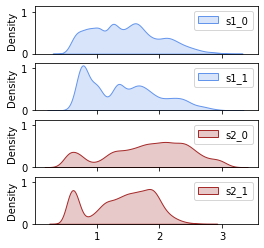

In [9]:
fig,axes = plt.subplots(4,1,sharex=True,sharey=True,figsize=[4,4])

names = ['s1_0','s1_1','s2_0','s2_1']
idx = 0
for ax,alpha in zip(axes,[s1alpha_0,s1alpha_1,s2alpha_0,s2alpha_1]):
    if 's1' in names[idx]:
        c = 'cornflowerblue'
    else:
        c = 'brown'
    sns.kdeplot(x=alpha,ax=ax,fill=True,label=names[idx],color=c)
    ax.legend()
    idx+=1
    

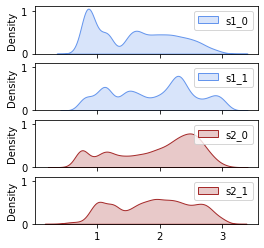

In [87]:
fig,axes = plt.subplots(4,1,sharex=True,sharey=True,figsize=[4,4])

names = ['s1_0','s1_1','s2_0','s2_1']
idx = 0
for ax,alpha in zip(axes,[s1alpha_0,s1alpha_1,s2alpha_0,s2alpha_1]):
    if 's1' in names[idx]:
        c = 'cornflowerblue'
    else:
        c = 'brown'
    sns.kdeplot(x=alpha,ax=ax,fill=True,label=names[idx],color=c)
    ax.legend()
    idx+=1
    

(0.0, 3.141592653589793)

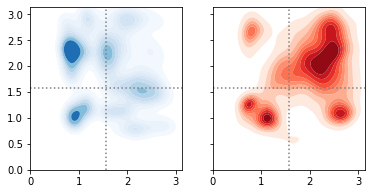

In [88]:
fig,ax = plt.subplots(1,2,figsize=[6,3],sharey=True,sharex=True)

sns.kdeplot(x=s1alpha_0,y=s1alpha_1,ax=ax[0],shade=True,antialiased=True,cmap='Blues')
sns.kdeplot(x=s2alpha_0,y=s2alpha_1,ax=ax[1],shade=True,antialiased=True,cmap='Reds')

for x in ax:
    x.axhline(np.pi/2,c='gray',ls=':')
    x.axvline(np.pi/2,c='gray',ls=':')
x.set_xlim(0,np.pi)
x.set_ylim(0,np.pi)

In [35]:
def compute_rg_monomer(system,chain_id,domains,selection='CA'):
    indices = get_monomer_domain_indices(system.top,domains['all'],chain=chain_id,selection=selection) 
    return md.compute_rg(system.atom_slice(indices))

s1rg_0 = compute_rg_monomer(s1s1,0,domains)
s1rg_1 = compute_rg_monomer(s1s1,1,domains)

s2rg_0 = compute_rg_monomer(s2s2,0,domains)
s2rg_1 = compute_rg_monomer(s2s2,1,domains)

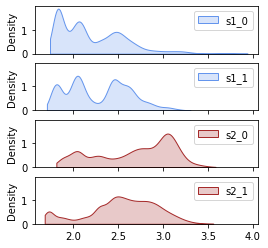

In [43]:
fig,axes = plt.subplots(4,1,sharex=True,sharey=True,figsize=[4,4])

names = ['s1_0','s1_1','s2_0','s2_1']
idx = 0
for ax,alpha in zip(axes,[s1rg_0,s1rg_1,s2rg_0,s2rg_1]):
    if 's1' in names[idx]:
        c = 'cornflowerblue'
    else:
        c = 'brown'
    sns.kdeplot(x=alpha,ax=ax,fill=True,label=names[idx],color=c,cut=0)
    ax.legend()
    idx+=1

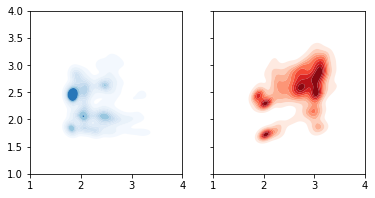

In [42]:
fig,ax = plt.subplots(1,2,figsize=[6,3],sharey=True,sharex=True)
ax = ax.flatten()
sns.kdeplot(ax=ax[0],x=s1rg_0,y=s1rg_1,shade=True,antialiased=True,cmap='Blues')
sns.kdeplot(ax=ax[1],x=s2rg_0,y=s2rg_1,shade=True,antialiased=True,cmap='Reds')
for i in ax:
    i.set_xlim(1,4)
    i.set_ylim(1,4)

<AxesSubplot:>

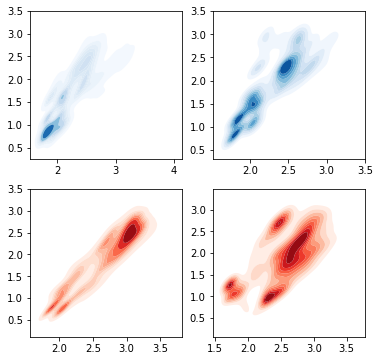

In [89]:
fig,ax=plt.subplots(2,2,figsize=[6,6])
ax = ax.flatten()
sns.kdeplot(ax=ax[0],x=s1rg_0,y=s1alpha_0,shade=True,antialiased=True,cmap='Blues')
sns.kdeplot(ax=ax[1],x=s1rg_1,y=s1alpha_1,shade=True,antialiased=True,cmap='Blues')
sns.kdeplot(ax=ax[2],x=s2rg_0,y=s2alpha_0,shade=True,antialiased=True,cmap='Reds')
sns.kdeplot(ax=ax[3],x=s2rg_1,y=s2alpha_1,shade=True,antialiased=True,cmap='Reds')

### Cluster Alpha's

In [90]:
from sklearn.cluster import KMeans

def kmcluster_alpha(alpha_0,alpha_1,n_clusters=10):
    X = np.array([alpha_0,alpha_1]).T
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    return X, kmeans

def plot_kmeans(ax, kmeans, X,pi=True):
    y_kmeans = kmeans.predict(X)
    ax.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=1, cmap='viridis',alpha=0.5)
    centers = kmeans.cluster_centers_
    ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
    if pi:
        ax.axhline(np.pi/2,c='gray',ls=':')
        ax.axvline(np.pi/2,c='gray',ls=':')
        ax.set_xlim(0,np.pi)
        ax.set_ylim(0,np.pi)
    return y_kmeans

In [91]:
n_clusters = 10
s1s1_X, s1s1_alpha_clusters = kmcluster_alpha(s1alpha_0,s1alpha_1,n_clusters)
s2s2_X, s2s2_alpha_clusters = kmcluster_alpha(s2alpha_0,s2alpha_1,n_clusters)

Text(0, 0.5, 'Alpha_1 (radians)')

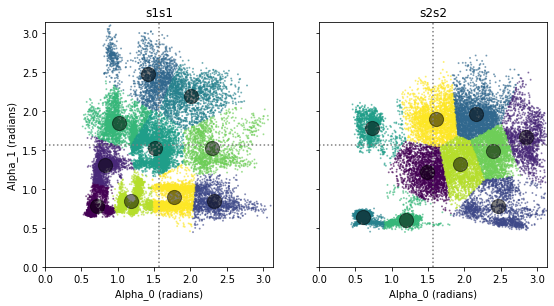

In [26]:
fig,ax=plt.subplots(1,2,figsize=[9,4.5],sharex=True,sharey=True)

s1s1_Y = plot_kmeans(ax[0],s1s1_alpha_clusters,s1s1_X)
s2s2_Y = plot_kmeans(ax[1],s2s2_alpha_clusters,s2s2_X)
ax[0].set_title('s1s1')
ax[1].set_title('s2s2')
ax[1].set_xlabel('Alpha_0 (radians)')
ax[0].set_xlabel('Alpha_0 (radians)')
ax[0].set_ylabel('Alpha_1 (radians)')

(0.0, 8.0)

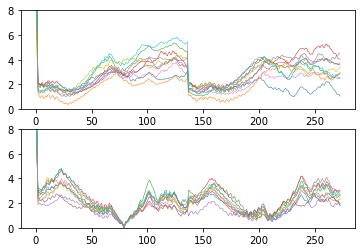

In [27]:
fig,ax=plt.subplots(2,1)
selection='CA'
for idx in range(n_clusters):
    rmsf = md.rmsf(s1s1[np.argwhere(s1s1_Y==idx).T[0]],s1s1[0],atom_indices=s1s1.top.select(f'name {selection}'))
    ax[0].plot(rmsf,lw=0.52)
    
for idx in range(n_clusters):
    rmsf = md.rmsf(s2s2[np.argwhere(s2s2_Y==idx).T[0]],s2s2[0],atom_indices=s2s2.top.select(f'name {selection}'))
    ax[1].plot(rmsf,lw=0.52)
ax[0].set_ylim(0,8)
ax[1].set_ylim(0,8)    

In [24]:
view = nv.show_mdtraj(s2s2[np.argwhere(s2s2_Y==2).T[0]].center_coordinates())
view

NGLWidget(max_frame=3230)

In [109]:
n_clusters = 4
s1_0_X, s1_0_clusters = kmcluster_alpha(s1alpha_0,s1rg_0,n_clusters)
s1_1_X, s1_1_clusters = kmcluster_alpha(s1alpha_1,s1rg_1,n_clusters)

Text(0, 0.5, 'Rg (nm)')

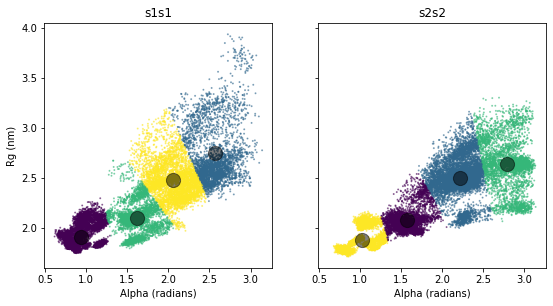

In [110]:
fig,ax=plt.subplots(1,2,figsize=[9,4.5],sharex=True,sharey=True)

s1_0_Y = plot_kmeans(ax[0],s1_0_clusters,s1_0_X,pi=False)
s2_1_Y = plot_kmeans(ax[1],s1_1_clusters,s1_1_X,pi=False)
ax[0].set_title('s1s1')
ax[1].set_title('s2s2')
ax[1].set_xlabel('Alpha (radians)')
ax[0].set_xlabel('Alpha (radians)')
ax[0].set_ylabel('Rg (nm)')

In [112]:
system = s1s1
c = 3 # clusterid
chain = 0
if chain == 0:
    Y = s1_0_Y
elif chain == 1:
    Y = s1_1_Y
    


view = nv.show_mdtraj(system[np.argwhere(Y==c).T[0]].center_coordinates())
view.clear()
#view.add_representation('cartoon',selection=system.top.select(f'chainid {1}'),color='red')
view.add_representation('cartoon',selection=system.top.select(f'chainid {chain}'),color='green')
view

NGLWidget(max_frame=4718)

### RMSD/RMSF analysis

In [9]:
def get_rmsd_domains(system,ref,domains,selection='CA'):
    data = {}
    for name,resids in domains.items():
        rms = []
        for chain_id in [0,1]:
            indices = get_monomer_domain_indices(system.top,resids,chain=chain_id,selection=selection)
            rms.append(md.rmsd(system,reference=ref,atom_indices=indices))
        data[name] = rms
    return data

In [10]:
selection = 'CA'
rmsds_s1 = {}
rmsds_s2 = {}
ref1 = s1s1[0] # open conf
ref2 = s2s2[0] # strechted conf
#ref1 = ref2

rmsds_s1s1 = get_rmsd_domains(s1s1,ref1,domains,selection)
rmsds_s2s2 = get_rmsd_domains(s2s2,ref2,domains,selection)

rmsf_s1s1 = md.rmsf(s1s1,ref1,atom_indices=s1s1.top.select(f'name {selection}'))
rmsf_s2s2 = md.rmsf(s2s2,ref2,atom_indices=s2s2.top.select(f'name {selection}'))

### plot RMSF

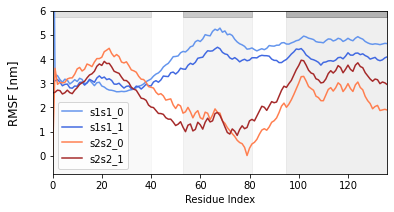

In [11]:
def plot_rmsf_monomer(ax,rmsf,label=None,fill=False,color='gray'):
    colors = sns.color_palette('Greys',5)[1:4]
    
    idx = 0
    for name,resids in domains.items():
        if idx > 2:
            break
        if fill:
            ax.fill_between(resids,[6]*len(resids),[5.75]*len(resids),alpha=0.5,color=colors[idx])
            ax.fill_between(resids,[-0.75]*len(resids),[5.75]*len(resids),alpha=0.1,color=colors[idx])
        idx+=1
    ax.plot(rmsf,label=label,color=color)
    
fig,ax =plt.subplots(1,1,sharey=True,sharex=True,figsize=[6,3])

n = len(rmsf_s1s1)
s1rmsf_a = rmsf_s1s1[:n//2]
s1rmsf_b = rmsf_s1s1[n//2:]
s2rmsf_a = rmsf_s2s2[:n//2]
s2rmsf_a[0] = 0
s2rmsf_b = rmsf_s2s2[n//2:]

plot_rmsf_monomer(ax,s1rmsf_a,fill=False,color='cornflowerblue',label='s1s1_0')
plot_rmsf_monomer(ax,s1rmsf_b,color='royalblue',label='s1s1_1')
plot_rmsf_monomer(ax,s2rmsf_a,fill=True,color='coral',label='s2s2_0')
plot_rmsf_monomer(ax,s2rmsf_b,color='brown',label='s2s2_1')

ax.set_xlim(0,136)
ax.set_ylim(-0.75,6)

list(domains.keys())[:]

fig.supylabel('RMSF [nm]')
ax.set_xlabel('Residue Index')
ax.legend()

### plot RMSD

Text(128.625, 0.5, 'RMSD [nm]')

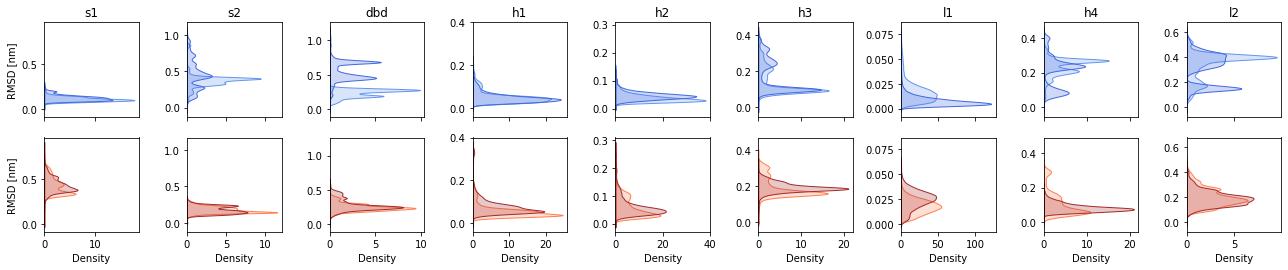

In [ ]:
fig,axes = plt.subplots(2,len(list(rmsds_s1s1.keys())),figsize=[18,3.5],sharey='col',sharex='col')
fig.tight_layout()

ax = axes[0]
idx = 0
for domain,monomers in rmsds_s1s1.items():
    sns.kdeplot(ax=ax[idx],y=monomers[0],fill=True,color='cornflowerblue')
    sns.kdeplot(ax=ax[idx],y=monomers[1],fill=True,color='royalblue')
    ax[idx].set_title(domain)
    idx+=1
ax[0].set_ylabel('RMSD [nm]')
    
ax = axes[1]
idx = 0
for domain,monomers in rmsds_s2s2.items():
    sns.kdeplot(ax=ax[idx],y=monomers[0],fill=True,color='coral')
    sns.kdeplot(ax=ax[idx],y=monomers[1],fill=True,color='brown')
    idx+=1
ax[0].set_ylabel('RMSD [nm]')
    

Text(0.5, 0.01, 'RMSD [nm]')

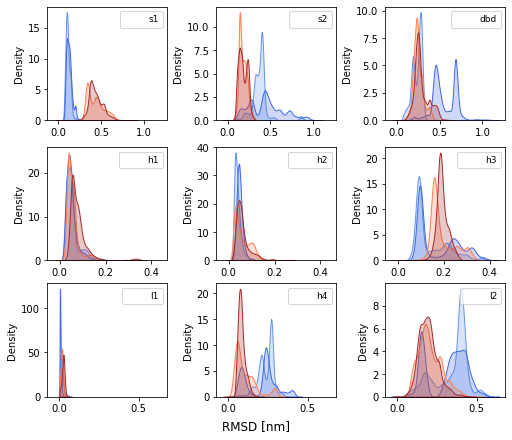

In [ ]:
fig,axes = plt.subplots(3,3,figsize=[7,6],sharex='row',sharey=False,constrained_layout=True)

from matplotlib.lines import Line2D
ax = axes.flatten()
idx = 0
for domain,monomers in rmsds_s1s1.items():
    sns.kdeplot(ax=ax[idx],x=monomers[0],fill=True,color='cornflowerblue')
    sns.kdeplot(ax=ax[idx],x=monomers[1],fill=True,color='royalblue')
    # ax[idx].set_title(domain)
    ax[idx].legend(domain,loc="upper right")
    
    legend_elements = [Line2D([0], [0], color='gray', lw=0, label=domain)]
    ax[idx].legend(handles=legend_elements, loc='upper right',fontsize=9)

    idx+=1
#ax[0].set_ylabel('RMSD [nm]')
    
ax = axes.flatten()
idx = 0
for domain,monomers in rmsds_s2s2.items():
    sns.kdeplot(ax=ax[idx],x=monomers[0],fill=True,color='coral')
    sns.kdeplot(ax=ax[idx],x=monomers[1],fill=True,color='brown')
    idx+=1
    
fig.supxlabel('RMSD [nm]')
    

### Domain Analysis

In [ ]:
# contacts between interdomains en intradomains 

In [152]:
system = s1s1
top = system.top
selection = 'CA'
monomer = 1
domain_indices = {name:get_monomer_domain_indices(top, domain, chain=monomer, selection=selection) for name,domain in domains.items()}


In [153]:
def get_contacts(system,domain_indices,domain_A,domain_B):
    indices_A = domain_indices[domain_A]
    indices_B = domain_indices[domain_B]
    pairs = [[i,j] for i in indices_A for j in indices_B]
    distances = md.compute_distances(system,pairs)
#    return pairs,distances
    return np.mean(distances,axis=1)

In [154]:
keys = ['s1','s2','dbd']
pairs = [[A,B] for A in keys for B in keys if A!=B]
pairs = np.unique(np.sort(pairs),axis=0)

C = [get_contacts(system,domain_indices,A,B) for A,B in pairs]

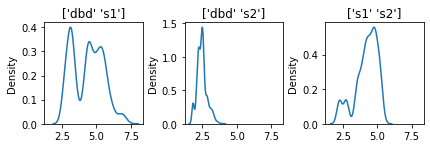

In [119]:
fig,axes = plt.subplots(1,len(pairs),figsize=[2*len(pairs),2],sharex=True,sharey=False)
axes = axes.flatten()
fig.tight_layout()
idx = 0
for ax,c in zip(axes,C):
    sns.kdeplot(c,ax=ax)
    ax.set_title(str(pairs[idx]))
    idx+=1
    
# s1s1

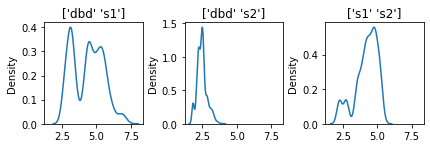

In [120]:
fig,axes = plt.subplots(1,len(pairs),figsize=[2*len(pairs),2],sharex=True,sharey=False)
axes = axes.flatten()
fig.tight_layout()
idx = 0
for ax,c in zip(axes,C):
    sns.kdeplot(c,ax=ax)
    ax.set_title(str(pairs[idx]))
    idx+=1
    
# s2s2

In [151]:
len(np.array(C[0].T,dtype=float))
len(s1rg_0)

20016

In [159]:
n_clusters = 3
s1_0_X, s1_0_clusters = kmcluster_alpha(C[0].T,s1rg_0,n_clusters)
s1_1_X, s1_1_clusters = kmcluster_alpha(C[0].T,s1alpha_0,n_clusters)

Text(0, 0.5, 'Rg (nm)')

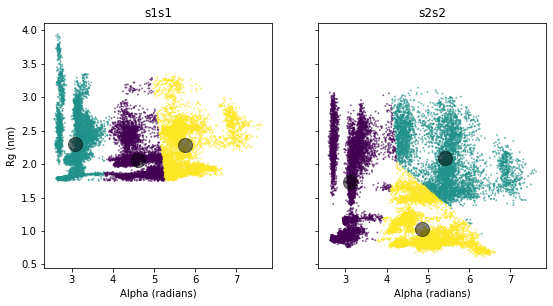

In [160]:
fig,ax=plt.subplots(1,2,figsize=[9,4.5],sharex=True,sharey=True)

s1_0_Y = plot_kmeans(ax[0],s1_0_clusters,s1_0_X,pi=False)
s2_1_Y = plot_kmeans(ax[1],s1_1_clusters,s1_1_X,pi=False)
ax[0].set_title('s1s1')
ax[1].set_title('s2s2')
ax[1].set_xlabel('Alpha (radians)')
ax[0].set_xlabel('Alpha (radians)')
ax[0].set_ylabel('Rg (nm)')

In [ ]:
# configurational bias monte carlo filament generation 

In [164]:
system = s1s1
c = 2 # clusterid
chain = 0
if chain == 0:
    Y = s1_0_Y
elif chain == 1:
    Y = s1_1_Y
    


view = nv.show_mdtraj(system[np.argwhere(Y==c).T[0]].center_coordinates())
view.clear()
#view.add_representation('cartoon',selection=system.top.select(f'chainid {1}'),color='red')
view.add_representation('cartoon',selection=system.top.select(f'chainid {chain}'),color='green')
view

NGLWidget(max_frame=5472)